In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from src.dataloaders import FPathDataset, FPathLazyDataset

In [2]:
dataset = FPathLazyDataset("/home/work/joono/VTFSketch/dataset/val.yaml")

In [3]:
def draw_gray_img(img):
    plt.figure(figsize=(10.24, 10.24))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
def draw_img(img):
    plt.figure(0, figsize=(10.24, 10.24))
    plt.imshow(img)
    plt.axis('off')

In [4]:
def save_vtf_gif(vtf):
    from IPython.display import Image as Img
    from IPython.display import display
    
    infodraw = Image.fromarray(vtf[10] * 255)
    infodraw.save("out.gif", save_all=True, append_images=[Image.fromarray(vtf[i] * 255) for i in range(21)], loop=0xff, duration=500)

(21, 1024, 1024) (3, 1024, 1024) (1, 1024, 1024) (1, 1024, 1024)


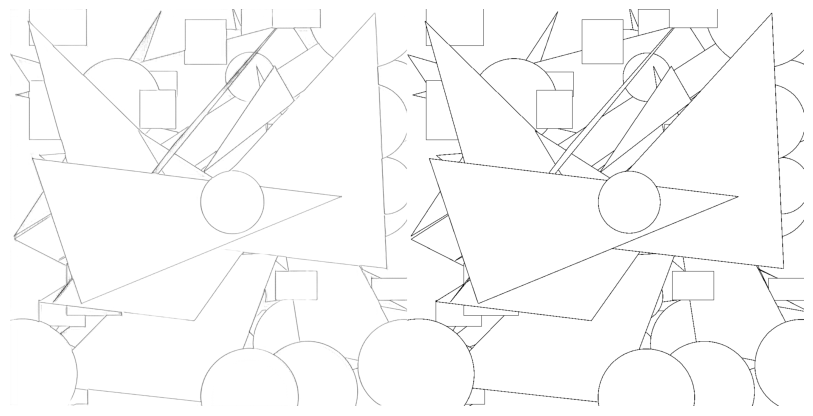

In [5]:
vtf, img, infodraw, target = dataset[6]
vtf, img, infodraw, target = np.array(vtf), np.array(img), np.array(infodraw), np.array(target)

print(vtf.shape, img.shape, infodraw.shape, target.shape)
draw_gray_img(np.concatenate([infodraw[0], target[0]], axis=1))

In [21]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

from sklearn.metrics import precision_score, recall_score

In [25]:

@interact(threshold_w=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.99, description='Threshold W'),
          threshold_b=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.0, description='Threshold B'))
def display_visualizations(threshold_w, threshold_b):
    global infodraw
    
    # Create an RGB image by stacking the grayscale image
    infodraw_rgb = np.stack([infodraw[0], infodraw[0], infodraw[0]], axis=2)
    
    # Apply thresholds
    infodraw_rgb[np.where(infodraw[0] < threshold_w)] = [1.0, 0.0, 0.0]
    infodraw_rgb[np.where(infodraw[0] < threshold_b)] = [0.0, 0.0, 1.0]
    
    # print precision and recall
    precision   = precision_score((1-target).flatten(), (infodraw[0] < threshold_b).flatten())
    recall      = recall_score((1-target).flatten(), (infodraw[0] < threshold_w).flatten())
    print(f"precision: {precision}, recall: {recall}")
    
    # Display the image
    plt.figure(figsize=(20.48, 10.24))
    
    plt.subplot(1, 2, 1)
    plt.imshow(infodraw_rgb)
    plt.axis('off')
    
    # Display the histogram
    plt.subplot(1, 2, 2)
    plt.hist(infodraw[0][np.where(infodraw[0] < threshold_w)], bins=100)
    plt.axvline(x=threshold_w, color='r', linestyle='--')
    plt.axvline(x=threshold_b, color='b', linestyle='--')
    plt.ylim(0.0, 10000)
    plt.xlim(0.0, 1.0)
    plt.show()

interactive(children=(FloatSlider(value=0.99, description='Threshold W', max=1.0, step=0.01), FloatSlider(valu…

In [23]:
precision = precision_score((1-target).flatten(), (infodraw[0] < 0.8).flatten())

In [24]:
precision

0.5365932759179849